In [2]:
import re
import os
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter, defaultdict

# sklearn for TF-IDF + LDA (optional later)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# NLTK for sentence tokenization (install if necessary)
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
#small sample dataset for demo
sample_abstracts = [
    {"id":"A1", "text":"PSA (Prostate-specific antigen) is used to monitor prostate cancer prognosis and recurrence."},
    {"id":"A2", "text":"CA-125 levels are indicative of ovarian cancer progression; high CA-125 correlates with advanced stage."},
    {"id":"A3", "text":"CEA (Carcinoembryonic antigen) is elevated in colorectal and some lung cancers and is used in prognosis."},
    {"id":"A4", "text":"HER2 overexpression associates with aggressive breast cancer and guides prognosis and therapy."},
    {"id":"A5", "text":"EGFR mutations and PD-L1 expression have prognostic and therapeutic implications in lung adenocarcinoma."},
    {"id":"A6", "text":"KRAS and BRAF mutations are frequently observed in colorectal cancer and affect prognosis and treatment response."},
    {"id":"A7", "text":"CA19-9 is used as a biomarker for pancreatic cancer monitoring and prognosis in clinical settings."},
    {"id":"A8", "text":"BRCA1 and BRCA2 germline mutations are associated with hereditary breast and ovarian cancer risk and prognosis."},
    {"id":"A9", "text":"ALK rearrangements in lung cancer affect prognosis and predict response to targeted inhibitors."},
    {"id":"A10","text":"PD-L1 expression across several cancers can indicate prognosis and predict response to immunotherapy."}
]

df = pd.DataFrame(sample_abstracts)
df.head()

,id,text
0,A1,PSA (Prostate-specific antigen) is used to mon...
1,A2,CA-125 levels are indicative of ovarian cancer...
2,A3,CEA (Carcinoembryonic antigen) is elevated in ...
3,A4,HER2 overexpression associates with aggressive...
4,A5,EGFR mutations and PD-L1 expression have progn...


In [7]:
#Text cleaning & simple preprocessing
def clean_text(text):
    text = text.strip()
    text = text.replace("\n", " ")
    text = re.sub(r"\[[^\]]*\]", " ", text)       # remove things like [1]
    text = re.sub(r"http\S+", " ", text)          # remove URLs
    text = re.sub(r"[^A-Za-z0-9\-\s\.,()]", " ", text)  # keep standard punctuation, dash, parens
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df['clean_text'] = df['text'].apply(clean_text)
df['clean_text'].head()

,clean_text
0,PSA (Prostate-specific antigen) is used to mon...
1,CA-125 levels are indicative of ovarian cancer...
2,CEA (Carcinoembryonic antigen) is elevated in ...
3,HER2 overexpression associates with aggressive...
4,EGFR mutations and PD-L1 expression have progn...


In [9]:
# Biomarker and cancer dictionaries (starter curated list)
biomarker_dict = {
    "psa": "PSA",
    "prostate-specific antigen": "PSA",
    "ca-125": "CA-125",
    "ca125": "CA-125",
    "cea": "CEA",
    "her2": "HER2",
    "egfr": "EGFR",
    "pd-l1": "PD-L1",
    "pdl1": "PD-L1",
    "kras": "KRAS",
    "braf": "BRAF",
    "ca19-9": "CA19-9",
    "ca199": "CA19-9",
    "brca1": "BRCA1",
    "brca2": "BRCA2",
    "alk": "ALK"
}

cancer_dict = {
    "prostate": "Prostate Cancer",
    "ovarian": "Ovarian Cancer",
    "colorectal": "Colorectal Cancer",
    "breast": "Breast Cancer",
    "lung": "Lung Cancer",
    "pancreatic": "Pancreatic Cancer",
    "hereditary breast": "Breast Cancer",
    "ovarian cancer": "Ovarian Cancer",
    "lung adenocarcinoma": "Lung Cancer",
    "melanoma": "Melanoma"
}


In [11]:
# Extract biomarkers and cancers by matching dictionary keys in text
def extract_entities(text):
    text_l = text.lower()
    found_biomarkers = set()
    for k,v in biomarker_dict.items():
        if re.search(r"\b"+re.escape(k)+r"\b", text_l):
            found_biomarkers.add(v)
    found_cancers = set()
    for k,v in cancer_dict.items():
        if re.search(r"\b"+re.escape(k)+r"\b", text_l):
            found_cancers.add(v)
    return list(found_biomarkers), list(found_cancers)

# Apply to dataframe
df['biomarkers'], df['cancers'] = zip(*df['clean_text'].apply(extract_entities))
df[['id','clean_text','biomarkers','cancers']]


,id,clean_text,biomarkers,cancers
0,A1,PSA (Prostate-specific antigen) is used to mon...,[PSA],[Prostate Cancer]
1,A2,CA-125 levels are indicative of ovarian cancer...,[CA-125],[Ovarian Cancer]
2,A3,CEA (Carcinoembryonic antigen) is elevated in ...,[CEA],"[Colorectal Cancer, Lung Cancer]"
3,A4,HER2 overexpression associates with aggressive...,[HER2],[Breast Cancer]
4,A5,EGFR mutations and PD-L1 expression have progn...,"[EGFR, PD-L1]",[Lung Cancer]
5,A6,KRAS and BRAF mutations are frequently observe...,"[BRAF, KRAS]",[Colorectal Cancer]
6,A7,CA19-9 is used as a biomarker for pancreatic c...,[CA19-9],[Pancreatic Cancer]
7,A8,BRCA1 and BRCA2 germline mutations are associa...,"[BRCA2, BRCA1]","[Breast Cancer, Ovarian Cancer]"
8,A9,ALK rearrangements in lung cancer affect progn...,[ALK],[Lung Cancer]
9,A10,PD-L1 expression across several cancers can in...,[PD-L1],[]


In [12]:
# Build co-occurrence counts (edges)
edge_counter = Counter()
for _, row in df.iterrows():
    bms = row['biomarkers']
    cts = row['cancers']
    for b in bms:
        for c in cts:
            edge_counter[(b,c)] += 1

# Convert to DataFrame of edges
edges = pd.DataFrame([{'biomarker':b,'cancer':c,'count':cnt} for (b,c),cnt in edge_counter.items()])
edges = edges.sort_values(by='count', ascending=False).reset_index(drop=True)
edges
# optional: save
edges.to_csv("biomarker_cancer_edges.csv", index=False)


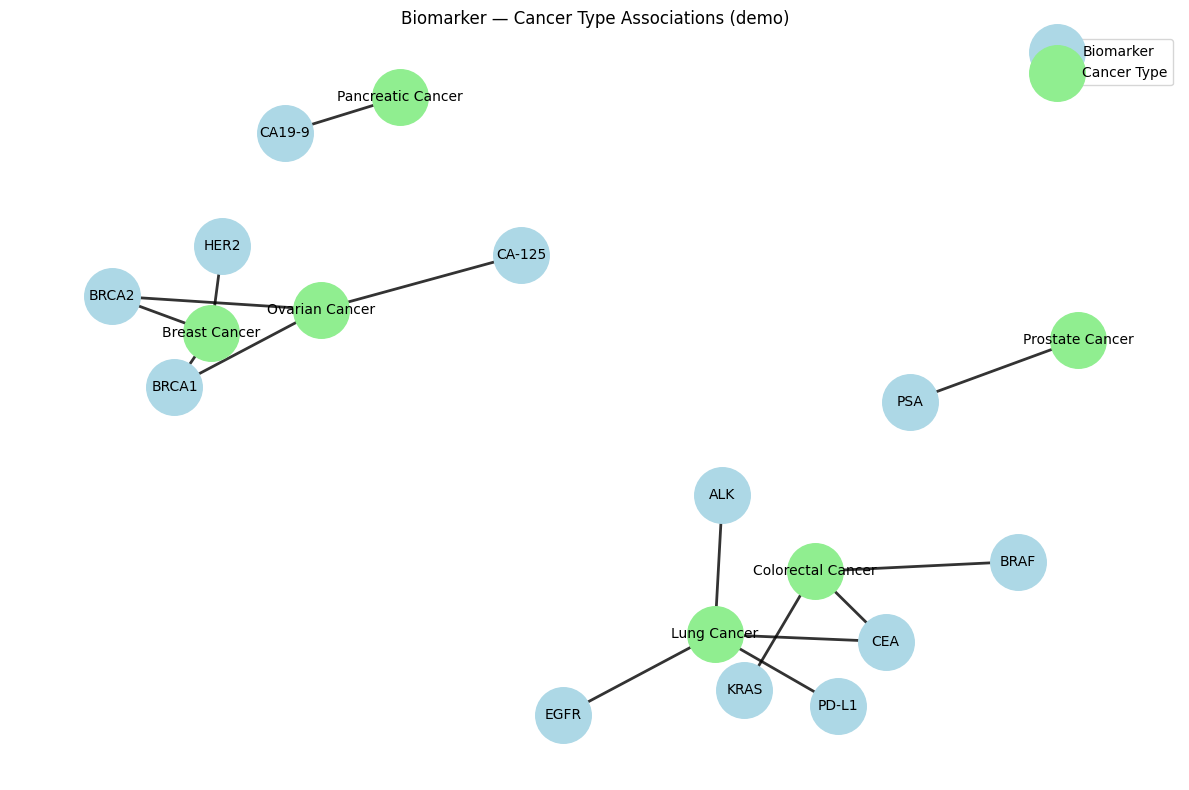

Saved network image to: biomarker_cancer_network.png


In [13]:
# Cell 7: Build a bipartite network and plot with NetworkX
# Create Graph
B = nx.Graph()
# Add nodes for biomarkers (type='biomarker') and cancers (type='cancer')
bm_nodes = sorted(edges['biomarker'].unique())
ct_nodes = sorted(edges['cancer'].unique())

B.add_nodes_from(bm_nodes, bipartite=0, node_type='biomarker')
B.add_nodes_from(ct_nodes, bipartite=1, node_type='cancer')

# Add weighted edges
for _, row in edges.iterrows():
    B.add_edge(row['biomarker'], row['cancer'], weight=row['count'])

# Plotting: use spring layout with bipartite separation
pos = nx.spring_layout(B, seed=42, k=0.6)  # k controls spacing (experiment)
plt.figure(figsize=(12,8))
# Draw nodes: biomarkers on left-like, cancers on right-like via color
bm_nodes_draw = [n for n,d in B.nodes(data=True) if d['node_type']=='biomarker']
ct_nodes_draw = [n for n,d in B.nodes(data=True) if d['node_type']=='cancer']

nx.draw_networkx_nodes(B, pos, nodelist=bm_nodes_draw, node_color='lightblue', node_size=1600, label='Biomarker')
nx.draw_networkx_nodes(B, pos, nodelist=ct_nodes_draw, node_color='lightgreen', node_size=1600, label='Cancer Type')

# Draw edges with width proportional to count
edges_draw = B.edges(data=True)
edge_widths = [max(1, 2*data['weight']) for (_,_,data) in edges_draw]
nx.draw_networkx_edges(B, pos, width=edge_widths, alpha=0.8)

# Labels
nx.draw_networkx_labels(B, pos, font_size=10)
plt.axis('off')
plt.title("Biomarker — Cancer Type Associations (demo)")
plt.legend(scatterpoints = 1)
plt.tight_layout()
# Save image for LinkedIn
out_img = "biomarker_cancer_network.png"
plt.savefig(out_img, dpi=300)
plt.show()
print("Saved network image to:", out_img)


In [15]:
# TF-IDF -> LDA topic modeling to find latent themes
tfidf = TfidfVectorizer(max_features=500, ngram_range=(1,2))
X = tfidf.fit_transform(df['clean_text'])
feature_names = tfidf.get_feature_names_out()

# Do LDA on CountVectorizer (LDA prefers counts)
count_vec = CountVectorizer(max_features=500, ngram_range=(1,2))
count_data = count_vec.fit_transform(df['clean_text'])

lda = LatentDirichletAllocation(n_components=2, random_state=42)
lda.fit(count_data)

def show_lda_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx+1))
        print(" | ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
show_lda_topics(lda, count_vec.get_feature_names_out(), 8)


Topic 1:
and | cancer | prognosis | prognosis and | in | is | is used | used
Topic 2:
and | prognosis | mutations | pd | expression | l1 expression | pd l1 | l1


In [17]:
# Cell 9: Save edge list and node list for downstream use or dashboards
edges.to_csv("biomarker_cancer_edges.csv", index=False)
node_list = pd.DataFrame([{'node':n,'type':'biomarker'} for n in bm_nodes] +
                          [{'node':n,'type':'cancer'} for n in ct_nodes])
node_list.to_csv("biomarker_cancer_nodes.csv", index=False)
print("Saved edges and nodes as CSV.")


Saved edges and nodes as CSV.
